In [1]:
import seaborn as sns
sns.set(style='whitegrid')
import glob as gb 
import cv2        
import tensorflow as tf

In [2]:
import numpy as np # linear algebra
import pandas as pd 
import os
import tensorflow.keras as keras
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dense,GlobalAveragePooling2D, MaxPooling2D, Conv2D, Flatten, Dropout
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import RMSprop

In [3]:
number_pic_char = pd.read_csv('../number_pic_char.csv')

In [4]:
number_pic_char

,Unnamed: 0,name,total,train,test,bounding_box
0,0,Homer Simpson,2246,1909,337,612
1,1,Ned Flanders,1454,1236,218,595
2,2,Moe Szyslak,1452,1234,218,215
3,3,Lisa Simpson,1354,1151,203,562
4,4,Bart Simpson,1342,1141,201,554
5,5,Marge Simpson,1291,1097,194,557
6,6,Krusty The Clown,1206,1025,181,226
7,7,Principal Skinner,1194,1015,179,506
8,8,Charles Montgomery Burns,1193,1014,179,650
9,9,Milhouse Van Houten,1079,917,162,210


# Check folders

In [5]:
trainpath = '../data/familia_simpsons_train/'
testpath = '../data/familia_simpsons_test/'

In [6]:
for folder in os.listdir(trainpath):
    files = gb.glob(str(trainpath + folder + '/*.jpg'))
    print(f"For traing data, found {len(files)} in folder {folder}")

For traing data, found 913 in folder abraham_grampa_simpson
For traing data, found 1342 in folder bart_simpson
For traing data, found 2246 in folder homer_simpson
For traing data, found 1354 in folder lisa_simpson
For traing data, found 128 in folder maggie_simpson
For traing data, found 1291 in folder marge_simpson


In [7]:
acum = 0
for files in  os.listdir(testpath):
    acum += 1
print(f'For testing data , found {acum} files')

For testing data , found 248 files


# Check images

In [8]:
size = []
for folder in  os.listdir(trainpath): 
    files = gb.glob(str(trainpath + folder + '/*.jpg'))
    for file in files: 
        image = plt.imread(file)
        size.append(image.shape)
pd.Series(size).value_counts()

(480, 320, 3)    1139
(432, 288, 3)    1069
(480, 640, 3)     844
(432, 576, 3)     769
(416, 288, 3)     727
                 ... 
(393, 256, 3)       1
(256, 455, 3)       1
(363, 256, 3)       1
(283, 256, 3)       1
(424, 256, 3)       1
Length: 127, dtype: int64

In [9]:
size = []

files = gb.glob(str(testpath + '/*.jpg'))
for file in files: 
    image = plt.imread(file)
    size.append(image.shape)
pd.Series(size).value_counts()

(154, 103, 3)    53
(171, 114, 3)    42
(149, 103, 3)    28
(171, 229, 3)    22
(149, 206, 3)    19
(154, 206, 3)    14
(176, 156, 3)    13
(131, 177, 3)    11
(126, 223, 3)     9
(166, 114, 3)     6
(184, 124, 3)     5
(200, 132, 3)     3
(52, 46, 3)       2
(153, 206, 3)     2
(143, 189, 3)     2
(189, 257, 3)     2
(143, 194, 3)     2
(90, 120, 3)      1
(145, 257, 3)     1
(137, 183, 3)     1
(189, 129, 3)     1
(154, 97, 3)      1
(90, 60, 3)       1
(90, 82, 3)       1
(125, 125, 3)     1
(192, 128, 3)     1
(145, 129, 3)     1
(166, 229, 3)     1
(200, 144, 3)     1
(70, 46, 3)       1
dtype: int64

# Images into arrays

In [10]:
code_keys = []
code_values = [0,1,2,3,4,5]
for folder in  os.listdir(trainpath):
    code_keys.append(str(folder))
code = {code_keys[i]:code_values[i] for i in range(len(code_keys))}

In [11]:
def getcode(n):
    for x,y in code.items():
        if n == y:
            return x

In [12]:
s = 224

In [13]:
X_train = []
y_train = []
for folder in  os.listdir(trainpath) : 
    files = gb.glob(str(trainpath + folder + '/*.jpg'))
    for file in files: 
        image = cv2.imread(file)
        image_array = cv2.resize(image , (s,s))
        X_train.append(list(image_array))
        y_train.append(code[folder])

In [14]:
len(X_train)

7274

In [15]:
plt.figure(figsize=(20,20))
for n, i in enumerate(list(np.random.randint(0,len(X_train),9))) : 
    plt.subplot(6,6,n+1)
    plt.imshow(cv2.cvtColor( X_train[i],cv2.COLOR_BGR2RGB))   
    plt.axis('off')
    plt.title(getcode(y_train[i])) 

ValueError: 4 is not a valid value for name; supported values are 'Accent', 'Accent_r', 'Blues', 'Blues_r', 'BrBG', 'BrBG_r', 'BuGn', 'BuGn_r', 'BuPu', 'BuPu_r', 'CMRmap', 'CMRmap_r', 'Dark2', 'Dark2_r', 'GnBu', 'GnBu_r', 'Greens', 'Greens_r', 'Greys', 'Greys_r', 'OrRd', 'OrRd_r', 'Oranges', 'Oranges_r', 'PRGn', 'PRGn_r', 'Paired', 'Paired_r', 'Pastel1', 'Pastel1_r', 'Pastel2', 'Pastel2_r', 'PiYG', 'PiYG_r', 'PuBu', 'PuBuGn', 'PuBuGn_r', 'PuBu_r', 'PuOr', 'PuOr_r', 'PuRd', 'PuRd_r', 'Purples', 'Purples_r', 'RdBu', 'RdBu_r', 'RdGy', 'RdGy_r', 'RdPu', 'RdPu_r', 'RdYlBu', 'RdYlBu_r', 'RdYlGn', 'RdYlGn_r', 'Reds', 'Reds_r', 'Set1', 'Set1_r', 'Set2', 'Set2_r', 'Set3', 'Set3_r', 'Spectral', 'Spectral_r', 'Wistia', 'Wistia_r', 'YlGn', 'YlGnBu', 'YlGnBu_r', 'YlGn_r', 'YlOrBr', 'YlOrBr_r', 'YlOrRd', 'YlOrRd_r', 'afmhot', 'afmhot_r', 'autumn', 'autumn_r', 'binary', 'binary_r', 'bone', 'bone_r', 'brg', 'brg_r', 'bwr', 'bwr_r', 'cividis', 'cividis_r', 'cool', 'cool_r', 'coolwarm', 'coolwarm_r', 'copper', 'copper_r', 'crest', 'crest_r', 'cubehelix', 'cubehelix_r', 'flag', 'flag_r', 'flare', 'flare_r', 'gist_earth', 'gist_earth_r', 'gist_gray', 'gist_gray_r', 'gist_heat', 'gist_heat_r', 'gist_ncar', 'gist_ncar_r', 'gist_rainbow', 'gist_rainbow_r', 'gist_stern', 'gist_stern_r', 'gist_yarg', 'gist_yarg_r', 'gnuplot', 'gnuplot2', 'gnuplot2_r', 'gnuplot_r', 'gray', 'gray_r', 'hot', 'hot_r', 'hsv', 'hsv_r', 'icefire', 'icefire_r', 'inferno', 'inferno_r', 'jet', 'jet_r', 'magma', 'magma_r', 'mako', 'mako_r', 'nipy_spectral', 'nipy_spectral_r', 'ocean', 'ocean_r', 'pink', 'pink_r', 'plasma', 'plasma_r', 'prism', 'prism_r', 'rainbow', 'rainbow_r', 'rocket', 'rocket_r', 'seismic', 'seismic_r', 'spring', 'spring_r', 'summer', 'summer_r', 'tab10', 'tab10_r', 'tab20', 'tab20_r', 'tab20b', 'tab20b_r', 'tab20c', 'tab20c_r', 'terrain', 'terrain_r', 'turbo', 'turbo_r', 'twilight', 'twilight_r', 'twilight_shifted', 'twilight_shifted_r', 'viridis', 'viridis_r', 'vlag', 'vlag_r', 'winter', 'winter_r'

In [43]:
X_test = []
files = gb.glob(str(testpath + '/*.jpg'))
for file in files: 
    image = cv2.imread(file)
    image_array = cv2.resize(image , (s,s))
    X_test.append(list(image_array))

In [44]:
len(X_test)

248

# Model

In [45]:
X_train = np.array(X_train, dtype = 'float32')
X_test = np.array(X_test, dtype = 'float32')
y_train = np.array(y_train, dtype = 'int32')


print(f'X_train shape : {X_train.shape}')
print(f'X_test shape : {X_test.shape}')
print(f'y_train shape : {y_train.shape}')

X_train shape : (7274, 224, 224, 3)
X_test shape : (248, 224, 224, 3)
y_train shape : (7274,)


In [46]:
X_train = X_train/255.0
X_test = X_test/255.0

In [47]:
from sklearn.utils import shuffle
X_train, y_train = shuffle(X_train, y_train, random_state = 25)

In [48]:
from tensorflow.keras.applications import VGG16

In [49]:
vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=(224,224,3))
vgg16.trainable = False
vgg16.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [52]:
model = Sequential()
model.add(vgg16)
model.add(Flatten())
model.add(Dense(49, activation='relu'))
model.add(Dense(20, activation='relu'))
model.add(Dense(1, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_3 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_9 (Dense)              (None, 49)                1229361   
_________________________________________________________________
dense_10 (Dense)             (None, 20)                1000      
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 21        
Total params: 15,945,070
Trainable params: 1,230,382
Non-trainable params: 14,714,688
_________________________________________________________________


In [53]:
train = model.fit(X_train, y_train, epochs=20, batch_size=200, verbose=1)

Epoch 1/20


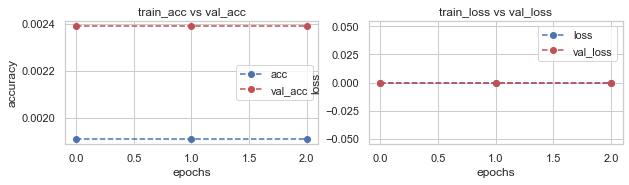

In [75]:
fig = plt.figure(figsize=(10,5))

plt.subplot(221)
plt.plot(history.history['accuracy'],'bo--', label = "acc")
plt.plot(history.history['val_accuracy'], 'ro--', label = "val_acc")
plt.title("train_acc vs val_acc")
plt.ylabel("accuracy")
plt.xlabel("epochs")
plt.legend()

plt.subplot(222)
plt.plot(history.history['loss'],'bo--', label = "loss")
plt.plot(history.history['val_loss'], 'ro--', label = "val_loss")
plt.title("train_loss vs val_loss")
plt.ylabel("loss")
plt.xlabel("epochs")

plt.legend()
plt.show()